In [38]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
data = pd.read_csv('Liver Patient Dataset (LPD)_train.csv', encoding='ISO-8859-1')
data.head()

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkphos,Sgpt,Sgot,Total_Protiens,Albumin,AG_Ratio,is_patient
0,65.0,Female,0.7,0.1,187.0,16.0,18.0,6.8,3.3,0.90,1
1,62.0,Male,10.9,5.5,699.0,64.0,100.0,7.5,3.2,0.74,1
2,62.0,Male,7.3,4.1,490.0,60.0,68.0,7.0,3.3,0.89,1
3,58.0,Male,1.0,0.4,182.0,14.0,20.0,6.8,3.4,1.00,1
4,72.0,Male,3.9,2.0,195.0,27.0,59.0,7.3,2.4,0.40,1


In [40]:
# Clean column names to remove leading/trailing spaces
data.columns = data.columns.str.strip()

In [41]:
# Check for missing values and handle them (simple mean/mode imputation)
numeric_columns = data.select_dtypes(include=['float64']).columns
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].mean())

In [42]:
# For the Gender column, fill missing values with the mode (most frequent value)
data['Gender'] = data['Gender'].fillna(data['Gender'].mode()[0])

# Convert Gender to numerical values (Male=1, Female=0)
data['Gender'] = data['Gender'].map({'Male': 1, 'Female': 0})

In [43]:
data.head()

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkphos,Sgpt,Sgot,Total_Protiens,Albumin,AG_Ratio,is_patient
0,65.0,0,0.7,0.1,187.0,16.0,18.0,6.8,3.3,0.90,1
1,62.0,1,10.9,5.5,699.0,64.0,100.0,7.5,3.2,0.74,1
2,62.0,1,7.3,4.1,490.0,60.0,68.0,7.0,3.3,0.89,1
3,58.0,1,1.0,0.4,182.0,14.0,20.0,6.8,3.4,1.00,1
4,72.0,1,3.9,2.0,195.0,27.0,59.0,7.3,2.4,0.40,1


In [44]:
# Map target values 1->0 (No liver disease), 2->1 (Has liver disease)
data['is_patient'] = data['is_patient'].map({1: 0, 2: 1})

In [45]:
data.groupby('is_patient').size()

is_patient
0    21917
1     8774
dtype: int64

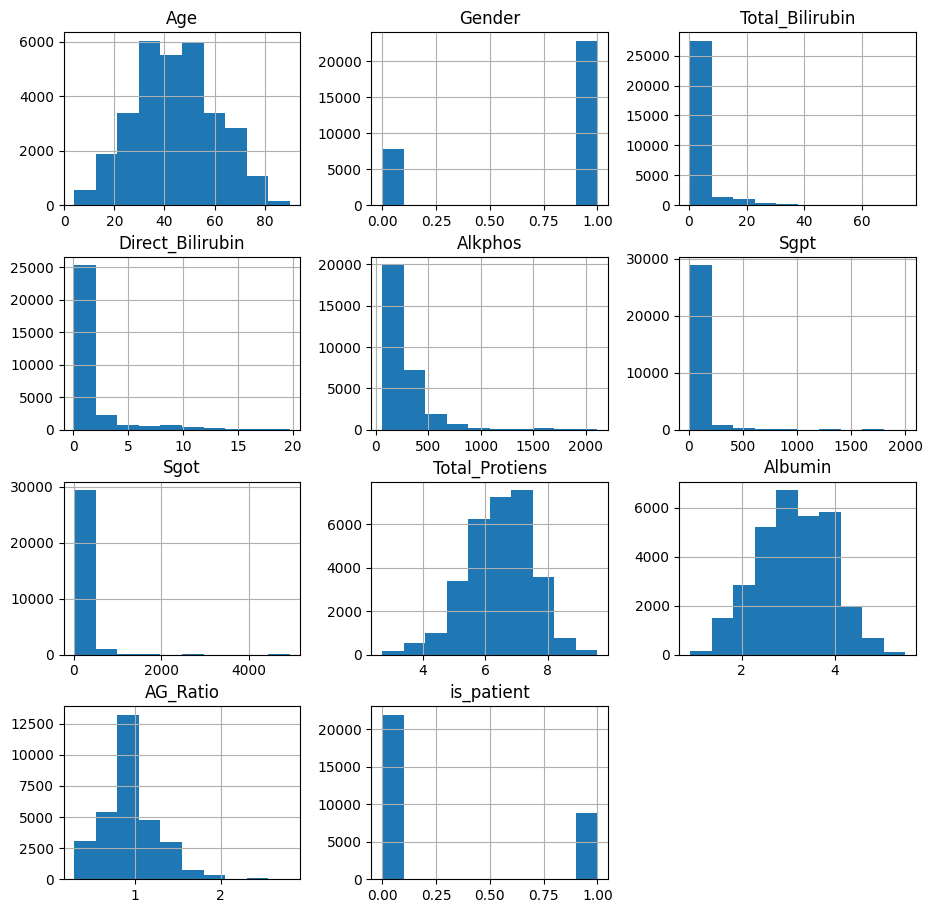

In [50]:
x=data.hist(figsize=(11, 11))

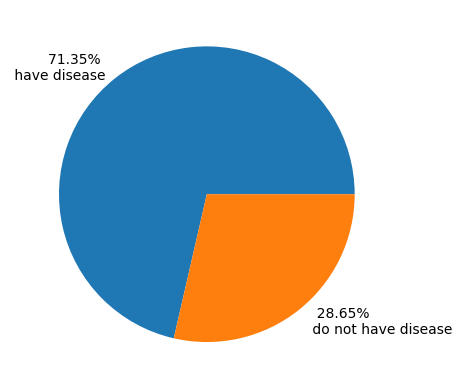

In [55]:
labels = ['71.35% \n have disease','  28.65% \n do not have disease']
values = [21917,8774]

plt.pie(values,labels=labels,radius=1)
plt.show()

<Axes: >

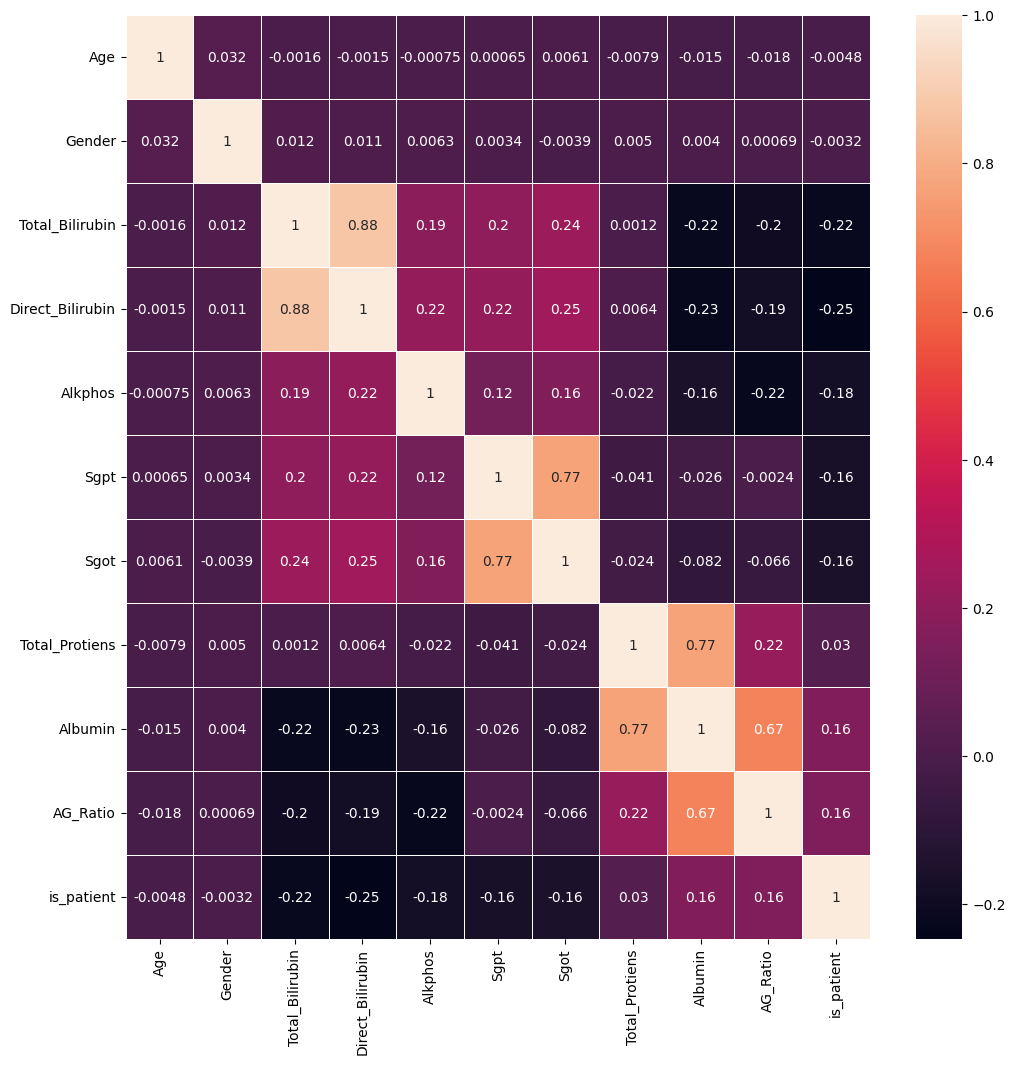

In [56]:
corr_matrix=data.corr()
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(corr_matrix,annot=True,linewidths=.5, ax=ax)

In [57]:
for value in data.iloc[:,0:10]:
    print (value,":", sum(data[value] == 0))

Age : 0
Gender : 7803
Total_Bilirubin : 0
Direct_Bilirubin : 0
Alkphos : 0
Sgpt : 0
Sgot : 0
Total_Protiens : 0
Albumin : 0
AG_Ratio : 0


In [58]:
data.isnull().sum()

Age                 0
Gender              0
Total_Bilirubin     0
Direct_Bilirubin    0
Alkphos             0
Sgpt                0
Sgot                0
Total_Protiens      0
Albumin             0
AG_Ratio            0
is_patient          0
dtype: int64

In [60]:
data.isna().sum()

Age                 0
Gender              0
Total_Bilirubin     0
Direct_Bilirubin    0
Alkphos             0
Sgpt                0
Sgot                0
Total_Protiens      0
Albumin             0
AG_Ratio            0
is_patient          0
dtype: int64

In [62]:
data=data.dropna(how='any',axis=0)

In [63]:
X = data.drop('is_patient', axis=1)  # Features
y = data['is_patient'] # Target

In [70]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score,classification_report

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [74]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [76]:
models = []

models.append(('KNN', KNeighborsClassifier(n_neighbors=15)))
models.append(('SVC', SVC(gamma=0.2)))
models.append(('LR', LogisticRegression(solver='lbfgs', max_iter=4000)))
models.append(('DT', DecisionTreeClassifier(criterion='entropy', max_depth=4)))
models.append(('GNB', GaussianNB()))
models.append(('RF', RandomForestClassifier(n_estimators=100)))
models.append(('ADB', AdaBoostClassifier(n_estimators=100, learning_rate=1, algorithm='SAMME')))
models.append(('GB', GradientBoostingClassifier(n_estimators=100, learning_rate=0.01, random_state=0)))
models.append(('XGB', XGBClassifier(learning_rate=0.1, subsample=0.8, objective='binary:logistic', n_estimators=100, max_depth=4, gamma=10)))


In [78]:
names = []
scores = []

for name, model in models:
    # For models that require scaling (KNN, SVC, XGBoost), use scaled data
    if name in ['KNN', 'SVC', 'XGB']:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    scores.append(accuracy_score(y_test, y_pred))
    names.append(name)

# Create a DataFrame to display the results
tr_split = pd.DataFrame({'Name': names, 'Score': scores})
print(tr_split)

  Name     Score
0  KNN  0.849696
1  SVC  0.769114
2   LR  0.724479
3   DT  0.737185
4  GNB  0.560708
5   RF  0.997176
6  ADB  0.723284
7   GB  0.730995
8  XGB  0.955474


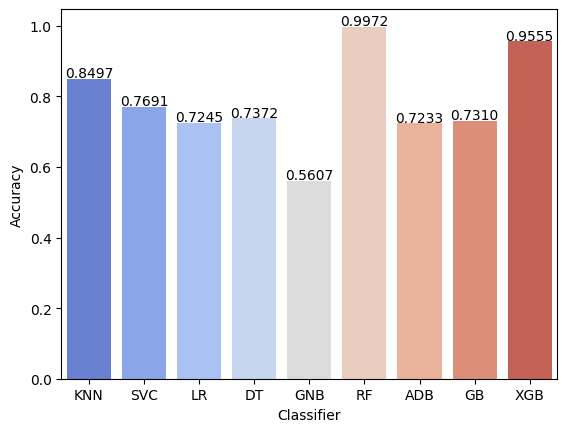

In [79]:
palette = sns.color_palette("coolwarm", len(tr_split))
axis = sns.barplot(x='Name', y='Score', data=tr_split, hue='Name', palette=palette, legend=False)

axis.set(xlabel='Classifier', ylabel='Accuracy')

for p in axis.patches:
    height = p.get_height()
    axis.text(p.get_x() + p.get_width()/2, height + 0.005, '{:1.4f}'.format(height), ha="center")
plt.show()

#plt.savefig('xx1.png', bbox_inches='tight')

PCA with Feature Scaling through standazation(Z score normalization)

In [81]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 4)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
explained_variance = pca.explained_variance_ratio_

In [82]:
# Initial model selection process
models = []

models.append(('KNN', KNeighborsClassifier(n_neighbors=15)))
models.append(('SVC', SVC(gamma=.2)))
models.append(('LR', LogisticRegression(solver='lbfgs', max_iter=4000)))
models.append(('DT', DecisionTreeClassifier(criterion='entropy',max_depth=4)))
models.append(('GNB', GaussianNB()))
models.append(('RF', RandomForestClassifier(n_estimators=100)))
models.append(('GB', GradientBoostingClassifier(n_estimators=100, learning_rate=.01, random_state=0)))
models.append(('XGB',  XGBClassifier(learning_rate=0.1,subsample = 0.8,objective='binary:logistic',n_estimators=100,max_depth=4,gamma=10)))

names = []
scores = []

for name,model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred))
    names.append(name)

tr_split = pd.DataFrame({'Name': names, 'Score': scores})
print(tr_split)
# tr_split.to_csv('PCAreasult.csv')

  Name     Score
0  KNN  0.911056
1  SVC  0.964270
2   LR  0.717420
3   DT  0.735882
4  GNB  0.496742
5   RF  0.994353
6   GB  0.725999
7  XGB  0.894440


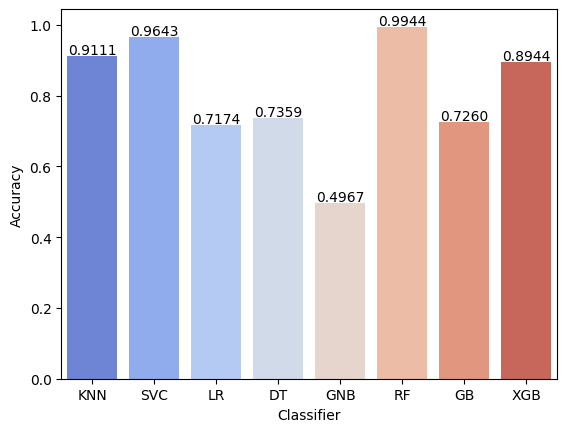

In [83]:
palette = sns.color_palette("coolwarm", len(tr_split))
axis = sns.barplot(x = 'Name', y = 'Score', data = tr_split, hue="Name", palette=palette, legend=False)

axis.set(xlabel='Classifier', ylabel='Accuracy')

for p in axis.patches:
    height = p.get_height()
    axis.text(p.get_x() + p.get_width()/2, height + 0.005, '{:1.4f}'.format(height), ha="center") 
    
plt.show()

Confusion Matrix

In [85]:
from sklearn.metrics import confusion_matrix

KNN


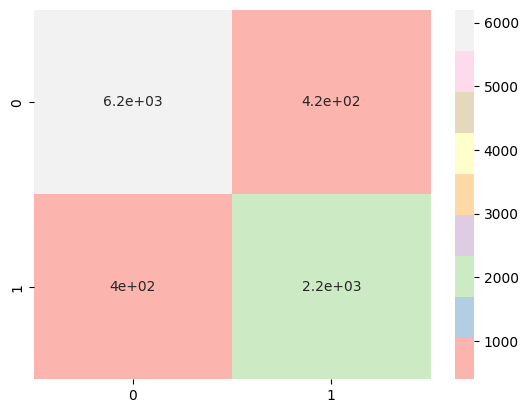

SVC


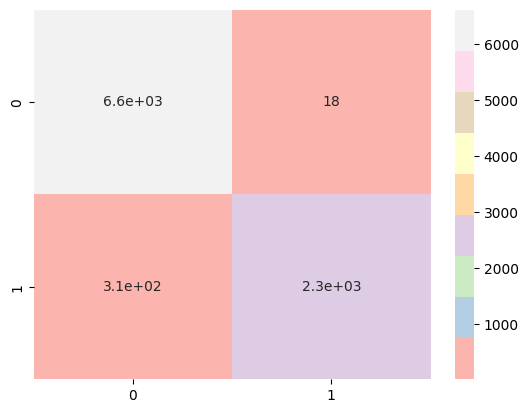

LR


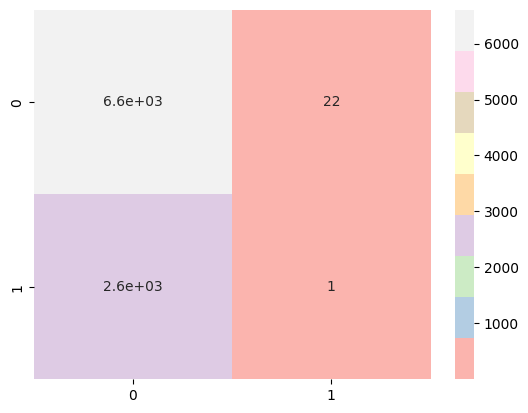

DT


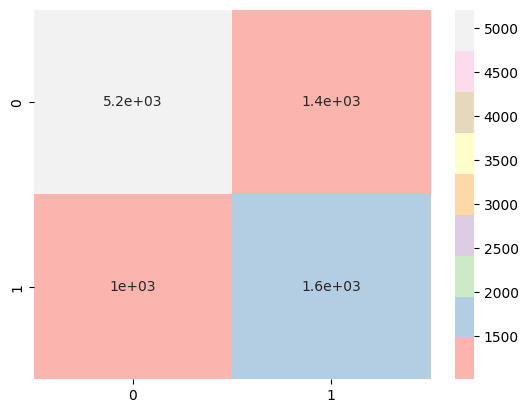

GNB


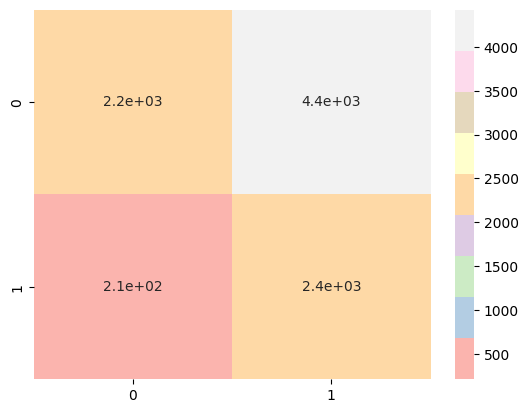

RF


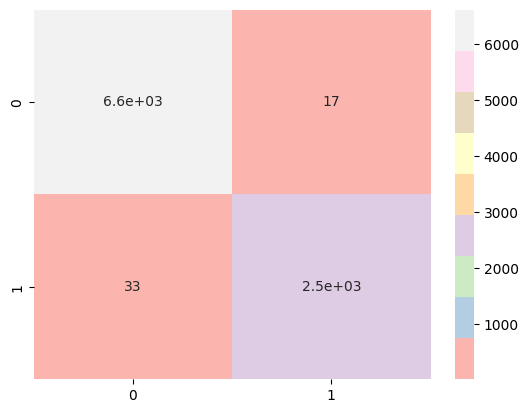

GB


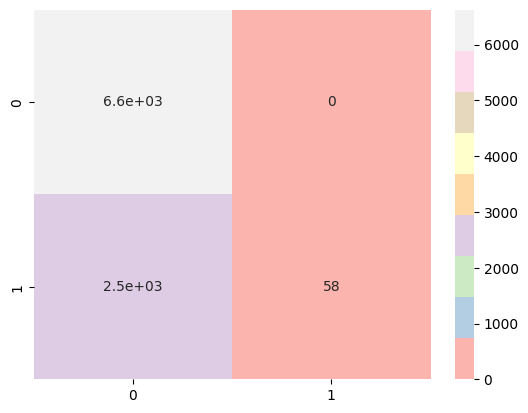

XGB


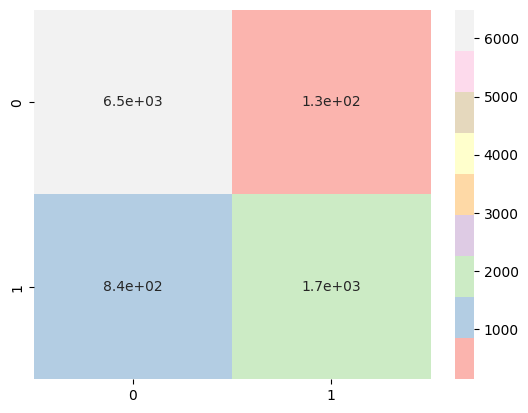

In [86]:
for name,model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,cmap='Pastel1')
    print(name)
    plt.show()

In [87]:
from sklearn import metrics
from sklearn.metrics import f1_score,matthews_corrcoef
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

fpr, tpr,_=roc_curve(model.predict(X_train),y_train,drop_intermediate=False)
names = []
AUC_score = []
precision=[]
Recall=[]
Accuracy=[]
F1_score=[]
Matthews_corrcoef=[]
specificity=[]
for name,model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    confusion = metrics.confusion_matrix(y_test, y_pred)
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    Accuracy.append(accuracy_score(y_test, y_pred))
    Recall.append(metrics.recall_score(y_test, y_pred))
    precision.append(metrics.precision_score(y_test, y_pred))
    AUC_score.append(roc_auc_score(y_test, y_pred))
    F1_score.append(f1_score(y_test,y_pred))
    Matthews_corrcoef.append(matthews_corrcoef(y_test,y_pred))
    specificity.append(TN / (TN + FP))
    names.append(name)

tr_split = pd.DataFrame({'Name': names, 'precision': precision,'Sensitivity':Recall,'F1 score':F1_score,'AUC score':AUC_score,'Accuracy':Accuracy,'Matthews corrcoef':Matthews_corrcoef,'specificity':specificity})
print(tr_split)

  Name  precision  Sensitivity  F1 score  AUC score  Accuracy  \
0  KNN   0.837807     0.846571  0.842166   0.891371  0.911056   
1  SVC   0.992133     0.879504  0.932430   0.938394  0.964270   
2   LR   0.043478     0.000387  0.000768   0.498534  0.717420   
3   DT   0.524941     0.607516  0.563218   0.696696  0.735882   
4  GNB   0.348933     0.918636  0.505759   0.625532  0.496742   
5   RF   0.992980     0.986439  0.989699   0.991862  0.994244   
6   GB   1.000000     0.022472  0.043956   0.511236  0.725999   
7  XGB   0.929984     0.674157  0.781671   0.827195  0.894440   

   Matthews corrcoef  specificity  
0           0.780270     0.936170  
1           0.911310     0.997284  
2          -0.026385     0.996680  
3           0.377425     0.785876  
4           0.256427     0.332428  
5           0.985715     0.997284  
6           0.127576     1.000000  
7           0.730454     0.980232  


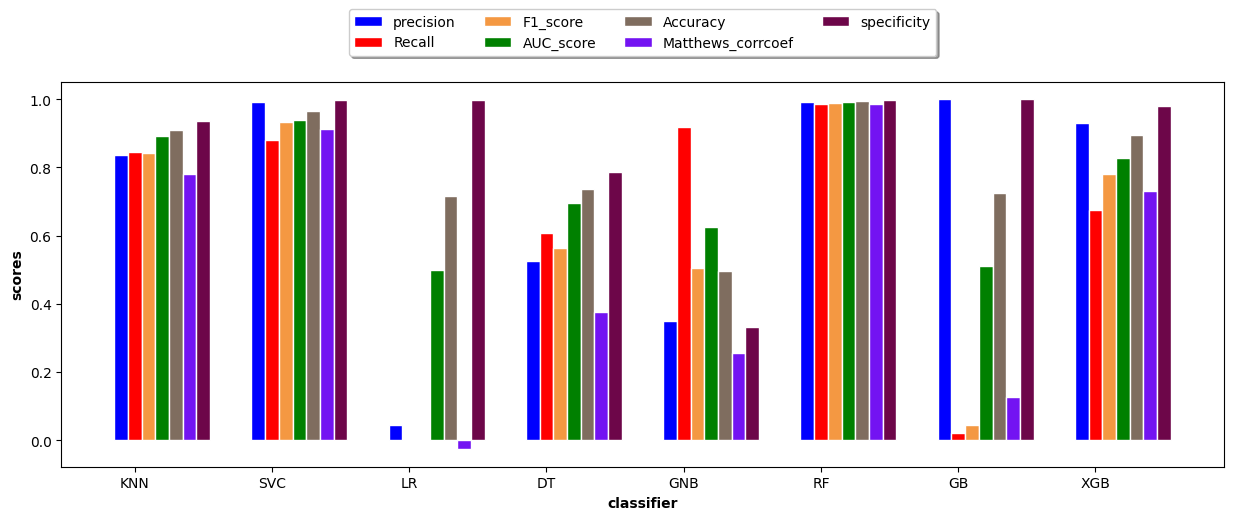

<Figure size 640x480 with 0 Axes>

In [88]:
barWidth = 0.1

r1 = np.arange(len(precision))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
r6 = [x + barWidth for x in r5]
r7 = [x + barWidth for x in r6]
 
# Make the plot
plt.subplots(figsize=(15,5))
plt.bar(r1, precision, color='blue', width=barWidth, edgecolor='white', label='precision')
plt.bar(r2, Recall, color='red', width=barWidth, edgecolor='white', label='Recall')
plt.bar(r3, F1_score, color='#f49842', width=barWidth, edgecolor='white', label='F1_score')
plt.bar(r4, AUC_score, color='green', width=barWidth, edgecolor='white', label='AUC_score')
plt.bar(r5, Accuracy, color='#7f6d5f', width=barWidth, edgecolor='white', label='Accuracy')
plt.bar(r6, Matthews_corrcoef, color='#7313f2', width=barWidth, edgecolor='white', label='Matthews_corrcoef')
plt.bar(r7, specificity, color='#6d0649', width=barWidth, edgecolor='white', label='specificity')
# Add xticks on the middle of the group bars
plt.xlabel('classifier', fontweight='bold')
plt.ylabel('scores', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(precision))], ['KNN', 'SVC', 'LR', 'DT', 'GNB','RF','GB','XGB'])
 
# Create legend & Show graphic
plt.legend(loc='lower center',bbox_to_anchor=(0.5,1.05),ncol=4,fancybox=True,shadow=True)
plt.show()
plt.savefig('Liver_Cancer_Prediction.png', bbox_inches='tight')

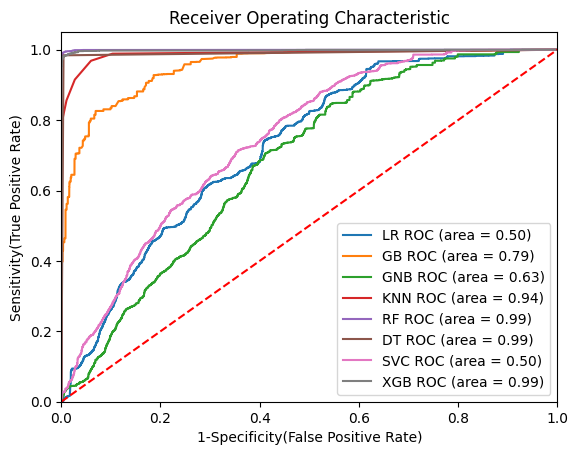

In [89]:
plt.figure()

# Add the models to the list that you want to view on the ROC plot
models = [
{
    'label': 'LR',
    'model': LogisticRegression(),
},
{
    'label': 'GB',
    'model': GradientBoostingClassifier(),
},    
{
    'label': 'GNB',
    'model': GaussianNB(),
}, 
{
    'label': 'KNN',
    'model': KNeighborsClassifier(),
},
{
    'label': 'RF',
    'model': RandomForestClassifier(),
},
{
    'label': 'DT',
    'model': DecisionTreeClassifier(),
},
{
    'label': 'SVC',
    'model': SVC(probability=True),
},
{
    'label': 'XGB',
    'model':  XGBClassifier(),
},
]


# Below for loop iterates through models list
for m in models:
    model = m['model'] # select the model
    model.fit(X_train, y_train) # train the model
    y_pred=model.predict(X_test) # predict the test data
    
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(X_test)[:,1])
    
# Calculate Area under the curve to display on the plot
    auc = metrics.roc_auc_score(y_test,model.predict(X_test))
    
# plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()